In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
# Set random seed for reproducibility
np.random.seed(42)

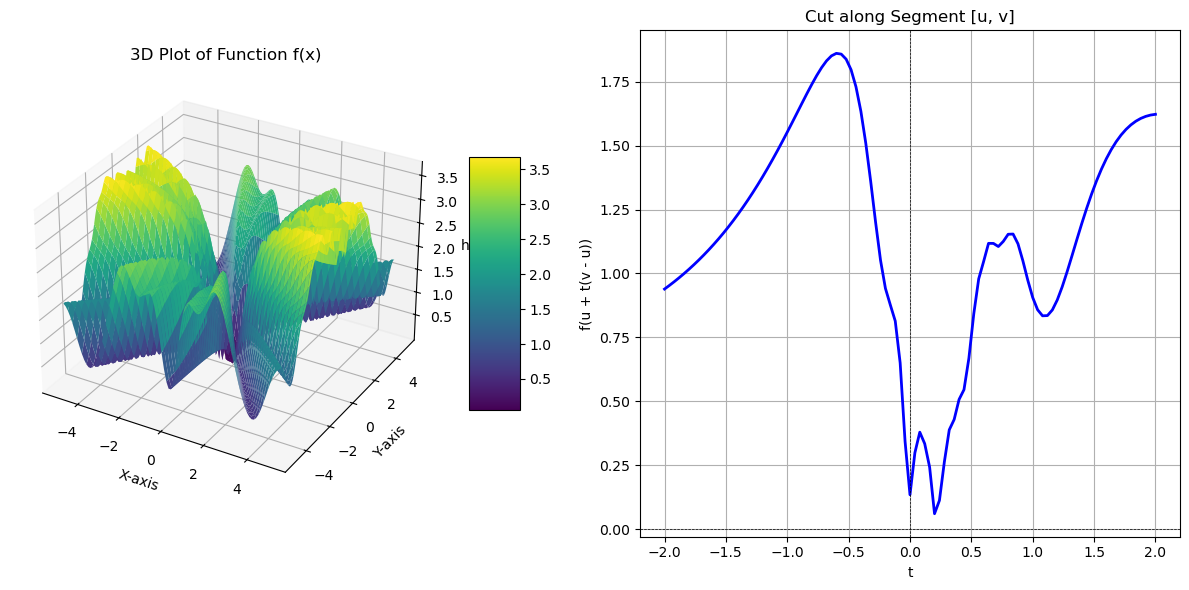

In [3]:
# Parameters for the function
N = 2
e = 25
a = np.random.uniform(0, 20, N)
b = np.random.uniform(-e, e, N)
c = np.random.uniform(0, 20, N)
d = np.random.uniform(-e, e, N)
# Define the function f(t) = t^2
def f(t):
    return (t**2) / (1+t**2)

# Define the function g(x1, x2)
def g1(x2):
    sum_terms = np.sum(c * np.cos(d * x2)**2)
    return (1 / (4 * N)) * sum_terms 
def g(x1, x2):
    sum_terms = np.sum(a * np.sin(b * x1)**2 + c * np.cos(d * x2)**2)
    return (1 / (4 * N)) * sum_terms 
# Define the function h(x) = f(||x||) * g(x / ||x||)
def h(x):
    norm_x = np.linalg.norm(x)
    if norm_x == 0:
        return 0  # Avoid division by zero
    x_unit = x / norm_x
    return f(norm_x) * g(x_unit[0], x_unit[1])
def h1(x):
    norm_x = np.linalg.norm(x)
    if norm_x == 0:
        return 0  # Avoid division by zero
    x_unit = x / norm_x
    return f(norm_x) * g1(x_unit)
    
# Generate a grid of points for plotting
x_values = np.linspace(-5, 5, 100)
y_values = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x_values, y_values)
Z = np.array([[h(np.array([x, y])) for x, y in zip(row_x, row_y)] for row_x, row_y in zip(X, Y)])

# Define segment endpoints in 2D for the cut
u = np.array([-2, 3])  # Starting point
v = np.array([2, -2]) 

# Generate points along the segment [u, v]
num_points = 101
segment_points = np.linspace(u, v, num_points)
# Calculate h(x) for each point in the segment
h_values = [h(point) for point in segment_points]

# Create the figure and subplots
fig = plt.figure(figsize=(12, 6))

# 3D Plot on the left
ax1 = fig.add_subplot(121, projection='3d')
surf = ax1.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
ax1.set_title('3D Plot of Function f(x)')
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Y-axis')
ax1.set_zlabel('h(x)')
fig.colorbar(surf, ax=ax1, shrink=0.5, aspect=5)
# 2D Cut Plot on the right
ax2 = fig.add_subplot(122)
ax2.plot(segment_points[:, 0], h_values, color='blue', linewidth=2)
ax2.set_title('Cut along Segment [u, v]')
ax2.set_xlabel('t')
ax2.set_ylabel('f(u + t(v - u))')
ax2.axhline(0, color='black',linewidth=0.5, ls='--')
ax2.axvline(0, color='black',linewidth=0.5, ls='--')
ax2.grid()

# Finalizing the figure layout
plt.tight_layout()
plt.savefig('Nonconvex.jpeg')
# Display the plot
plt.show()



In [4]:
# Projection function to ensure the norm of x does not exceed the given radius
def projection_func(x, radius):
    norm_x = np.linalg.norm(x)
    if norm_x > radius:
        x = (radius / norm_x) * x
    return x

# Function f(t) and its gradient
def f(t):
    return (t**2) / (1 + t**2)

def grad_f(t):
    return (2 * t) / (1 + 2 * t**2 + t**4)

# Function g(x, a, b) and its gradient
def g(x, a, b):
    return np.sum(a * np.sin(b * x)**2)

def grad_g(x, a, b):
    return a * b * np.sin(2 * b * x)

# Function h(x) = f(||x||) * g(x / ||x||)
def h(x, a, b):
    norm_x = np.linalg.norm(x)
    if norm_x == 0:
        return 0  # Avoid division by zero
    return f(norm_x) * g(x / norm_x, a, b)
# Gradient of h(x)
def grad_h(x, a, b):
    norm_x = np.linalg.norm(x)
    if norm_x == 0:
        return np.zeros_like(x)  # Avoid division by zero by returning zero gradient
    
    x_unit = x / norm_x  # Unit vector of x
    grad_f_term = grad_f(norm_x) * g(x_unit, a, b) * (x / norm_x)
    
    identity_matrix = np.eye(len(x))
    projection_matrix = identity_matrix - np.outer(x, x) / (norm_x**2)
    
    grad_g_term = (f(norm_x) / norm_x) * projection_matrix @ grad_g(x_unit, a, b)
    
    return grad_f_term + grad_g_term


In [5]:
def online_projected_gradient_descent(grad_h, projection_func, eta, num_iterations, initial_point, radius):
    """
    Online Projected Gradient Descent (OPGD) Algorithm.

    Parameters:
    - grad_h: function to compute the gradient of the objective function at the current point.
    - projection_func: function to project the point back to the feasible set.
    - eta: the learning rate or step size for the gradient descent update.
    - num_iterations: number of iterations to run the algorithm.
    - initial_point: starting point for the algorithm.
    - radius: radius of the feasible set.

    Returns:
    - regret_values: array of cumulative regret values at each iteration.
    """

    # Initialize the point and regret tracking
    x = initial_point
    cumulative_regret = 0
    regret_values = np.zeros(num_iterations)

    for t in range(num_iterations):
        # Randomly generate the parameters for the function g
        a = np.random.uniform(0, 1, len(initial_point))
        b = np.random.uniform(-2.5, 2.5, len(initial_point))
        # Update the cumulative regret and store its value
        cumulative_regret += h(x, a, b)
        # Compute the gradient at the current point
        grad = grad_h(x, a, b)

        # Gradient descent update step
        x = x - eta * grad

        # Projection step to ensure the updated point is within the feasible set
        x = projection_func(x, radius)

        # Update the cumulative regret and store its value
        #cumulative_regret += h(x, a, b)
        regret_values[t] = cumulative_regret
    return regret_values


In [6]:
# Parameters
num_iterations = 20000
radius = 100
dim = 100
Lip = dim + 2.5 * np.sqrt(dim)
initial_point = np.random.uniform(0.2, 0.3, dim)
eta =np.sqrt((4 * radius**2) / (num_iterations * Lip**2))
regret_values = online_projected_gradient_descent(grad_h, projection_func, eta, num_iterations, initial_point,radius)

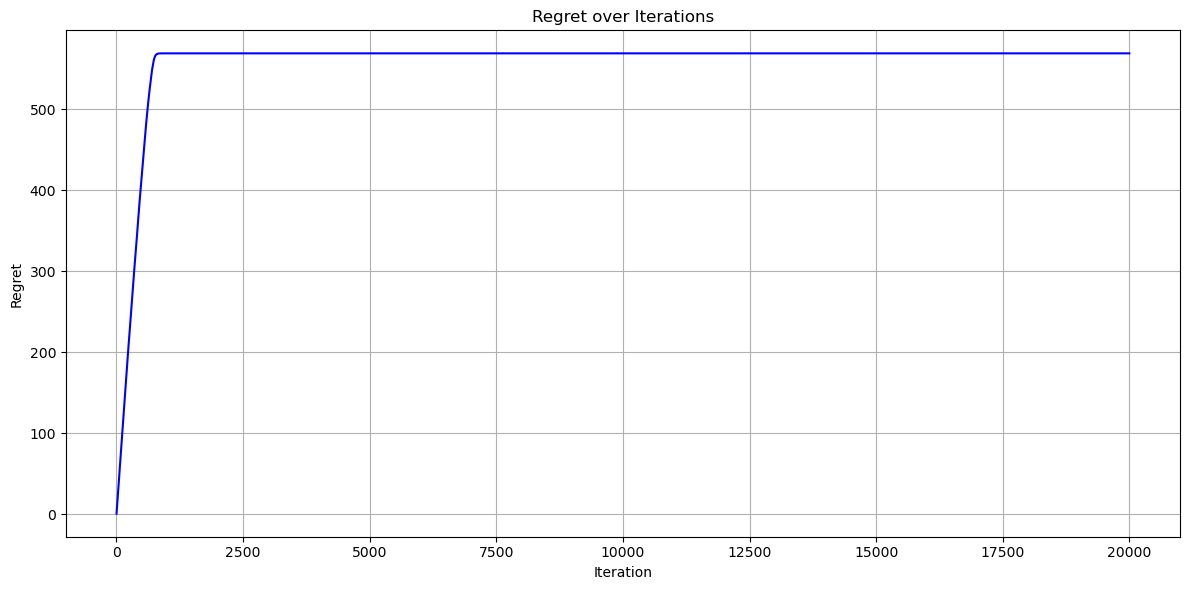

In [7]:
def plot_regret(regret_values, num_iterations):
    iterations = np.arange(1, num_iterations + 1)

    # Plot of regret values over iterations
    plt.figure(figsize=(12, 6))
    
    plt.plot(iterations, regret_values, label='Regret', color='blue')
    plt.title('Regret over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Regret')
    plt.grid(True)


    plt.tight_layout()
    plt.show()
# Plot the results
plot_regret(regret_values, num_iterations)

In [8]:
def plot_regrets(cases, grad_h, projection_func, eta, num_iterations, radius, vec_delays, max_delay):
    iterations = np.arange(1, num_iterations + 1)
    cases = int(cases)
    
    # To store regret values for multiple cases
    regret_values = np.zeros((num_iterations, cases))
    
    # Running the algorithm for each case
    for i in range(cases):
        initial_point = np.random.uniform(0.2, 0.4, dim)
        regret_values[:, i] = online_projected_gradient_descent(grad_h, projection_func, eta, num_iterations, initial_point, radius)
    
    # Compute mean and standard deviation for plotting shaded regions
    mean_regret = np.mean(regret_values, axis=1)
    std_regret = np.std(regret_values, axis=1)

    # Plot of regret values over iterations
    plt.figure(figsize=(10, 6))

    # Plot the mean regret line
    plt.plot(iterations, mean_regret, label='Mean Regret', color='green', lw=2)
    plt.legend(loc='best',fontsize='small')
    # Plot shaded area (mean ± std_dev)
    plt.fill_between(iterations, mean_regret - std_regret, mean_regret + std_regret, 
                     color='green', alpha=0.2, label='Regret ± Std Dev')

    # Add labels and grid
    plt.title('Regret over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Averaged regret')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig('ogd.jpeg')
    plt.show()

In [9]:
def plot_regrets(cases, grad_h, projection_func, eta, num_iterations, radius, vec_delays, max_delay):
    iterations = np.arange(1, num_iterations + 1)
    cases = int(cases)
    
    # To store regret values for multiple cases
    regret_values = np.zeros((num_iterations, cases))
    
    # Running the algorithm for each case
    for i in range(cases):
        initial_point = np.random.uniform(0.2, 0.4, dim)
        regret_values[:, i] = online_projected_gradient_descent(grad_h, projection_func, eta, num_iterations, initial_point, radius)
    
    # Compute mean and standard deviation for plotting shaded regions
    mean_regret = np.mean(regret_values, axis=1)
    min_regret = np.min(regret_values, axis=1)
    max_regret= np.max(regret_values, axis=1)
    # Plot of regret values over iterations
    plt.figure(figsize=(10, 6))

    # Plot the mean regret line
    plt.plot(iterations, mean_regret, label='Mean Regret', color='green', lw=2)
    plt.legend(loc='best',fontsize='small')
    # Plot shaded area (mean ± std_dev)
    plt.fill_between(iterations, min_regret, max_regret, 
                     color='green', alpha=0.2, label='Regret range')

    # Add labels and grid
    plt.title('Regret over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Averaged regret')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig('ogd.jpeg')
    plt.show()

In [10]:
max_delay = 1
delays = np.random.randint(1, max_delay+1, size=(num_iterations, 1))
# Initialize vec_delays as a list of empty lists
vec_delays = [[] for _ in range(num_iterations + max_delay)]

# Populate vec_delays with the delayed indices
for i in range(num_iterations):
    vec_delays[i + int(delays[i]) - 1].append(i)



C:\Users\cris_\AppData\Local\Temp\ipykernel_23144\820937039.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vec_delays[i + int(delays[i]) - 1].append(i)


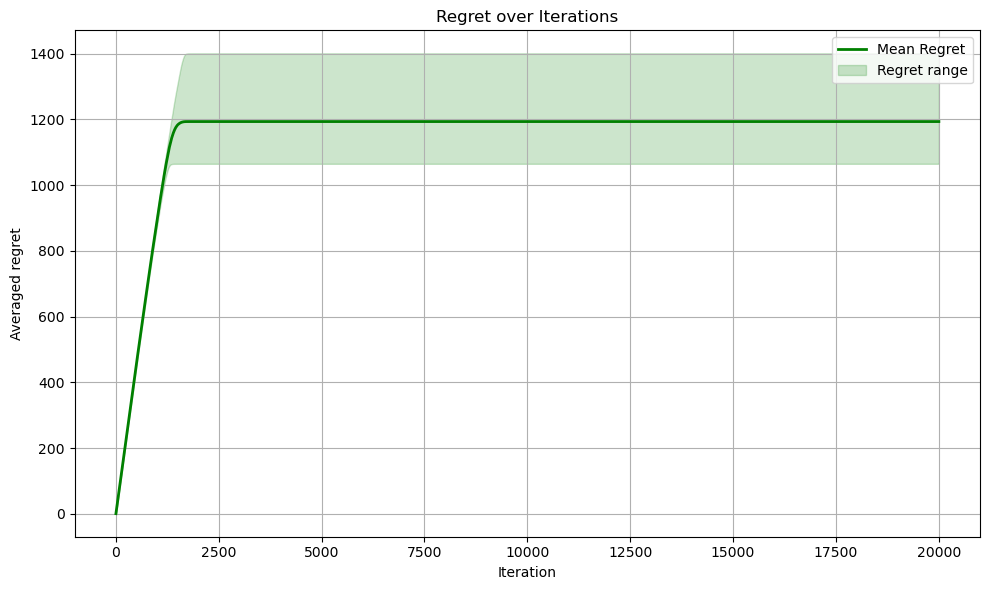

In [11]:
# Parameters
num_iterations = 20000
max_delay = 1
radius = 100
dim = 100
Lip = dim + 2.5 * np.sqrt(dim)
eta =np.sqrt((4 * radius**2) / (num_iterations * (5 * max_delay - 4) * Lip**2))
cases = 20
plot_regrets(20,grad_h, projection_func, eta, num_iterations, radius, vec_delays,max_delay)

In [12]:
def online_delayed_projected_gradient_descent(grad_h, projection_func, eta, num_iterations, initial_point, radius, vec_delays,max_delay):
    """
    Online Delayed Projected Gradient Descent Algorithm.

    Parameters:
    - grad_h: function to compute the gradient of the objective function.
    - projection_func: function to project the point back to the feasible set.
    - eta: the learning rate or step size for the gradient descent update.
    - num_iterations: number of iterations to run the algorithm.
    - initial_point: starting point for the algorithm.
    - radius: radius of the feasible set.
    - vec_delays: list of delays indicating when gradients arrive.

    Returns:
    - regret_values: array of cumulative regret values at each iteration.
    """

    # Initialize the point, regret tracking, and storage for x values
    x = initial_point
    cumulative_regret = 0
    regret_values = np.zeros(num_iterations)
    vec_iter = np.zeros((len(initial_point), num_iterations + int(max_delay)))

    for t in range(num_iterations+ int(max_delay)):
        grad = np.zeros_like(x)  # Initialize gradient to zero for each iteration
        vec_iter[:, t] = x  # Store the current point x in vec_iter

        # Process delayed gradients that arrive at this time step
        for j in vec_delays[t]:
            a = np.random.uniform(0, 1, len(initial_point))
            b = np.random.uniform(-2.5, 2.5, len(initial_point))
            
            # Compute the delayed gradient at the stored point
            x_old = vec_iter[:, j]
            grad += grad_h(x_old, a, b)
            
            # Update the regret value based on the delayed information
            regret_values[j] = h(x_old, a, b)

        # Gradient descent update step using the accumulated gradient
        x = x - eta * grad

        # Projection step to ensure the updated point is within the feasible set
        x = projection_func(x, radius)
    for k in range(num_iterations):
        # Update the cumulative regret and store its value
        cumulative_regret += regret_values[k]
        regret_values[k] = cumulative_regret

    return regret_values


In [13]:
def plot_regrets_delayed(cases, grad_h, projection_func, eta, num_iterations, radius, max_delay):
    iterations = np.arange(1, num_iterations + 1)
    cases = int(cases)
    
    # To store regret values for multiple cases
    regret_values = np.zeros((num_iterations, cases))
    
    # Running the algorithm for each case
    for i in range(cases):
        delays = np.random.randint(1, max_delay+1, size=(num_iterations, 1))
        # Initialize vec_delays as a list of empty lists
        vec_delays = [[] for _ in range(num_iterations + max_delay)]
        # Populate vec_delays with the delayed indices
        for j in range(num_iterations):
            vec_delays[j + int(delays[i]) - 1].append(j)
        initial_point = np.random.uniform(0.1, 0.3, dim)
        regret_values[:, i] =online_delayed_projected_gradient_descent(grad_h, projection_func, eta, num_iterations, initial_point, radius, vec_delays,max_delay)
    
    # Compute mean and standard deviation for plotting shaded regions
    mean_regret = np.mean(regret_values, axis=1)
    min_regret = np.min(regret_values, axis=1)
    max_regret= np.max(regret_values, axis=1)
    # Plot of regret values over iterations
    plt.figure(figsize=(10, 6))

    # Plot the mean regret line
    plt.plot(iterations, mean_regret, label='Mean Regret', color='blue', lw=2)
    plt.legend(loc='best',fontsize='small')

    # Plot shaded area (mean ± std_dev)
    plt.fill_between(iterations, min_regret, max_regret, 
                     color='blue', alpha=0.2, label='Regret range')

    # Add labels and grid
    plt.title('Regret over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Averaged regret')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig('delayed.jpeg')
    plt.show()

C:\Users\cris_\AppData\Local\Temp\ipykernel_23144\2351500549.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vec_delays[j + int(delays[i]) - 1].append(j)


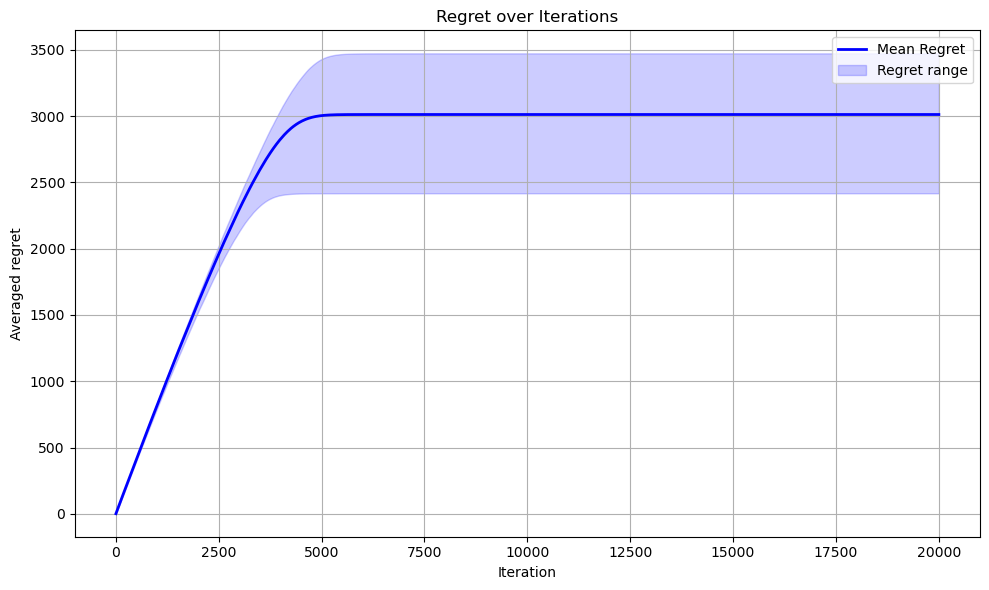

In [14]:
# Parameters
num_iterations = 20000
max_delay = 20
radius = 100
dim = 100
Lip = dim + 2.5 * np.sqrt(dim)
eta =np.sqrt((4 * radius**2) / (num_iterations * (5 * max_delay - 4) * Lip**2))
cases=50
plot_regrets_delayed(cases, grad_h, projection_func, eta, num_iterations, radius, max_delay)

In [15]:
def plot_regrets_delayed(cases, grad_h, projection_func, num_iterations, radius):
    iterations = np.arange(1, num_iterations + 1)
    cases = int(cases)
    delays_vec=[20, 50, 100, 150 ,200]
    regret_values_delay = np.zeros((num_iterations,len(delays_vec)))
    std_values_delay = np.zeros((num_iterations,len(delays_vec)))
    colors=['orange','green','yellow','aqua', 'maroon','fuchsia']
    count=-1
    for t in delays_vec:
        print(t)
        count=count+1
        # To store regret values for multiple cases
        regret_values = np.zeros((num_iterations, cases))
        # Running the algorithm for each case
        eta =np.sqrt((4 * radius**2) / (num_iterations * (5 * t- 4) * Lip**2))
        for i in range(cases):
            initial_point = np.random.uniform(0.2, 0.4, dim)
            delays = np.random.randint(1, t+1, size=(num_iterations, 1))
            # Initialize vec_delays as a list of empty lists
            vec_delays = [[] for _ in range(num_iterations + t)]
            # Populate vec_delays with the delayed indices
            for j in range(num_iterations):
                vec_delays[j + int(delays[j]) - 1].append(j)
            regret_values[:, i] = online_delayed_projected_gradient_descent(grad_h, projection_func, eta, num_iterations, initial_point, radius, vec_delays,t)
    
        # Compute mean and standard deviation for plotting shaded regions
        mean_regret = np.mean(regret_values, axis=1)
        std_regret = np.std(regret_values, axis=1)
        regret_values_delay[:, count] = mean_regret
        std_values_delay[:, count] = std_regret
        # min_regret = np.min(regret_values, axis=1)
        # max_regret= np.max(regret_values, axis=1)
        # Plot of regret values over iterations
        # plt.figure(figsize=(10, 6))

        # Plot the mean regret line
        plt.plot(iterations, mean_regret, label=f"d={t}", color=colors[count], lw=2)
        plt.legend(loc='best',fontsize='small')
        # Plot shaded area (mean ± std_dev)
        # plt.fill_between(iterations, mean_regret - std_regret, mean_regret + std_regret, 
        #              color=colors[count], alpha=0.2, label=f"Regret ± Std Dev with maximun delay {t}")
        plt.fill_between(iterations, mean_regret - std_regret, mean_regret + std_regret, 
                     color=colors[count], alpha=0.2)

    # Add labels and grid
    plt.title('Regret over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Averaged regret')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig('Delayed_cases1.jpeg')
    plt.show()
    return regret_values_delay, std_values_delay

20


C:\Users\cris_\AppData\Local\Temp\ipykernel_23144\2359625988.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vec_delays[j + int(delays[j]) - 1].append(j)


50
100
150
200


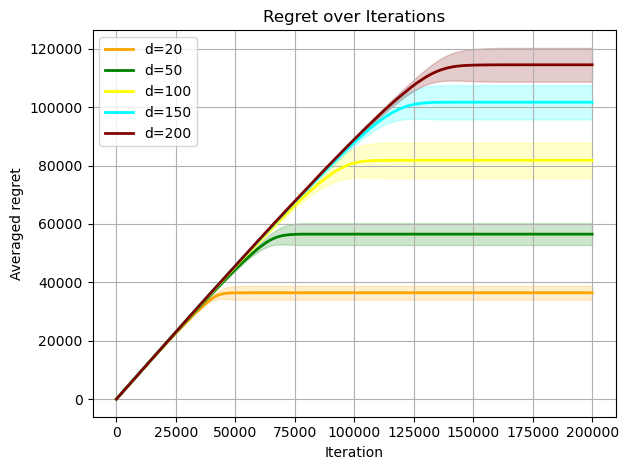

In [16]:
# Parameters
num_iterations = 200000
radius = 100
dim = 100
Lip = dim + 2.5 * np.sqrt(dim)
cases = 50
regret_values_delay, std_values_delay = plot_regrets_delayed(cases, grad_h, projection_func, num_iterations, radius)

In [19]:
tol=1e-1
vec_error= np.zeros((num_iterations,5))
for t in [0,1,2,3,4]:
    vec_error[0,t]= regret_values_delay[0,t]
    for i in range(num_iterations-1):
        vec_error[i,t]=(regret_values_delay[i+1,t]-regret_values_delay[i,t])
    count=0
    while vec_error[count,t]>tol:
        count=count+1
    print(count)

45694
71466
103445
127455
142963


In [20]:
print(vec_error)

[[9.31931299e-01 9.05588273e-01 8.99456774e-01 9.44626401e-01
  9.45338589e-01]
 [9.32196305e-01 9.13948951e-01 9.13742775e-01 9.28533153e-01
  9.09757229e-01]
 [9.19640391e-01 9.23755005e-01 9.56023940e-01 9.35202930e-01
  9.28901377e-01]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.91038305e-11]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  4.36557457e-11]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]]


In [21]:
std_values_delay[199999:200000,:]

array([[2375.71297218, 3746.62593425, 6024.5175838 , 5842.88402283,
        5784.98180518]])